In [423]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import os
import datetime
import time

#Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg

#Functionalities
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_absolute_error, mean_squared_error

parameters = {
    "dataset":{
        "path": "../data/Processed_Data/Demand_All_Exogenous.csv",
        "trainingSize": .70,
        "validationSize": .15,
        "testSize": .15
    },
    "backtesting":{
        "steps": 96,
        "fixedTrainSize": False,
        "refit": False,
    },
    "validation": {
        "n_splits" : 10
    }
}

In [424]:
#Read Dataset {Path Dataset}
df = pd.read_csv(parameters["dataset"]["path"])
df["Date"] = pd.to_datetime(df["Date"])

df.head(5)

Date  Demand  Year  Month  Hour  DayOfWeek  DayOfYear  Day  \
0 2018-01-01 00:15:00       8  2018      1     0          0          1    1   
1 2018-01-01 00:30:00       8  2018      1     0          0          1    1   
2 2018-01-01 00:45:00       8  2018      1     0          0          1    1   
3 2018-01-01 01:00:00       8  2018      1     1          0          1    1   
4 2018-01-01 01:15:00       8  2018      1     1          0          1    1   

   Minute  Temperature  ...  Sunshine_Duration  Shortwave_Radiation  \
0      15    12.967492  ...                0.0                  0.0   
1      30    12.972492  ...                0.0                  0.0   
2      45    12.977492  ...                0.0                  0.0   
3       0    12.982492  ...                0.0                  0.0   
4      15    12.709992  ...                0.0                  0.0   

   Direct_Shortwave_Radiation  Diffuse_Shortwave_Radiation  Demand_7d  \
0                         0.0                          0.0        0.0   
1                         0.0                          0.0        0.0   
2                         0.0                          0.0        0.0   
3                         0.0                          0.0        0.0   
4                         0.0                          0.0        0.0   

   isWeekend  Hour_sen  Hour_cos  Demand_24h  isHoliday  
0      False  0.000000  0.261799           0       True  
1      False  0.000000  0.261799           0       True  
2      False  0.000000  0.261799           0       True  
3      False  0.220297  0.141451           0       True  
4      False  0.220297  0.141451           0       True  

[5 rows x 22 columns]

In [425]:
#Dataset Split
#Podriamos probar otra estrategia para hacer el split
trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])
trainingLastDate = str(df.loc[[trainingSize+1]]["Date"].values[0])
validationLastDate = str(df.loc[[validationSize+1]]["Date"].values[0])

x_train = df.loc[:trainingSize, :].copy()
x_val = df.loc[trainingSize + 1: validationSize, :].copy()
x_test = df.loc[validationSize + 1:, :].copy()

df = df.set_index("Date")
df = df.asfreq("15min")
x_train = x_train.set_index("Date")
x_train = x_train.asfreq("15min")
x_val = x_val.set_index("Date")
x_val = x_val.asfreq("15min")
x_test = x_test.set_index("Date")
x_test = x_test.asfreq("15min")

print(f"Whole Dataset Size: {df.shape[0]}")
print(f"Trainig Dataset Size: {x_train.shape[0]} From: {x_train.index.min()} to {x_train.index.max()}")
print(f"Validation Dataset Size: {x_val.shape[0]} From: {x_val.index.min()} to {x_val.index.max()}")
print(f"Test Dataset Size: {x_test.shape[0]} From: {x_test.index.min()} to {x_test.index.max()}")

print(trainingLastDate)
print(validationLastDate)

Whole Dataset Size: 70080
Trainig Dataset Size: 49057 From: 2018-01-01 00:15:00 to 2019-05-27 00:15:00
Validation Dataset Size: 10512 From: 2019-05-27 00:30:00 to 2019-09-13 12:15:00
Test Dataset Size: 10511 From: 2019-09-13 12:30:00 to 2020-01-01 00:00:00
2019-05-27T00:30:00.000000000
2019-09-13T12:30:00.000000000


In [426]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train.index, y=x_train["Demand"], mode="lines", name="Train"))
fig.add_trace(go.Scatter(x=x_val.index, y=x_val["Demand"], mode="lines", name="Validation"))
fig.add_trace(go.Scatter(x=x_test.index, y=x_test["Demand"], mode="lines", name="Test"))
fig.update_layout(
    title = "Dataset Partition",
    xaxis_title = "Date",
    yaxis_title ="Demand (MWh)",
    width = 1000,
    height = 400,
    margin = dict(l=30, r=20, t=35, b=60),
    legend = dict(
        orientation = "h",
        yanchor = "bottom",
        y = 1.05,
        xanchor = "right",
        x=1
    )
)
fig.show()

In [427]:
#Equivalent Date (Baseline Model)
baselineForecaster = ForecasterEquivalentDate(
    offset= pd.DateOffset(weeks=1),
    n_offsets=2,
    agg_func=np.mean
)
baselineForecaster.fit(y=x_train["Demand"])
predictions = baselineForecaster.predict(steps = 21023)
predictions = predictions.to_frame()


In [428]:
def plotPredictions(preds, tests):
    fig = go.Figure()
    trace1 = go.Scatter(x=tests.index, y=tests["Demand"], name="test", mode="lines")
    trace2 = go.Scatter(x=preds.index, y=preds["pred"], name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

In [429]:
#EquivalentDate Algorithm Results 1 Week
#test_dates = df.loc[(df.index > x_val.index.min()) & (df.index <= x_val.index.min()+datetime.timedelta(weeks=1))]

print(f"MAE: {mean_absolute_error(df[trainingLastDate:].Demand.values, predictions.pred.values)}, MSE: {mean_squared_error(df[trainingLastDate:].Demand.values, predictions.pred.values)}")
plotPredictions(preds=predictions, tests=df[trainingLastDate:])

MAE: 22.59277933691671, MSE: 1408.7759120962755


In [430]:
def run_backtesting(model, data, initial_train_size, params):
    init = time.time()
    forecaster = ForecasterAutoreg(
        regressor = model,
        #transformer_y = StandardScaler(),
        lags=1
    )
    #forecaster.fit(y=data["Demand"], exog=exog)
    metrics, predictions = backtesting_forecaster(
        forecaster = forecaster,
        steps = len(x_test),
        y = data["Demand"],
        metric = ['mean_absolute_error', 'mean_squared_error'],
        exog = data[["Demand_7d", "Hour_cos", "DayOfWeek"]],
        initial_train_size = initial_train_size,
        refit = params["backtesting"]["refit"],
        fixed_train_size = parameters["backtesting"]["fixedTrainSize"],
        verbose = False,
        show_progress = True,
        n_jobs='auto'
    )
    end = time.time()
    return predictions, metrics, (end-init)

In [431]:
models = {
    #'LGBM': LGBMRegressor(n_estimators=100, random_state=123, verbose=-1),
    #'XGBoost': XGBRegressor(n_estimators=100, random_state=123),
    'KNNR': KNeighborsRegressor(n_neighbors=20, weights='distance'),
    #"SVR": SVR(kernel='rbf'),
    #'GBM': GradientBoostingRegressor(n_estimators=100, random_state=123),
    #'RF': RandomForestRegressor(n_estimators=100, random_state=123),
    #'ADA': AdaBoostRegressor(n_estimators=100, random_state=123)
}
results = {}
for model_name, model in models.items():
    predictions, metrics, model_time = run_backtesting(model, df, len(x_train)+len(x_val), parameters)
    results[model_name] = {
        'predictions': predictions,
        'MAE': metrics[0],
        'MSE': metrics[1],
        'Time': model_time
    }
    print(f"Model {model_name}: MAE: {metrics[0]}, MSE: {metrics[1]}, Time: {model_time:.6f} seconds")

    

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

Model KNNR: MAE: 39.396475844276694, MSE: 2195.3868287094188, Time: 2.651865 seconds


In [432]:
knn_regressor = KNeighborsRegressor(n_neighbors=20, weights='uniform')
train_val_df = pd.concat([x_train, x_val])
train_val_df.reset_index(inplace=True)
x_test.reset_index(inplace=True)

X_train = train_val_df[["Hour_cos","Demand_7d", "DayOfWeek", "Demand_24h"]]
y_train = train_val_df["Demand"]
X_test = x_test[["Hour_cos", "Demand_7d", "DayOfWeek", "Demand_24h"]]
knn_regressor.fit(X = X_train, y=y_train)
predictions = knn_regressor.predict(X = X_test)
print(f"MAE: {mean_absolute_error(x_test.Demand.values, predictions)}, MSE: {mean_squared_error(x_test.Demand.values, predictions)}")


MAE: 24.99735515174579, MSE: 1533.2902292836075


### Hyperparameter Tuning

In [433]:
from skforecast.model_selection import grid_search_forecaster

#Lags used as Predictors
lags_grid = [[96], [24*7], [96*7], [96, 96*7]]

#Regressor Hyperparameters
param_grid = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

forecaster = ForecasterAutoreg(
    regressor = KNeighborsRegressor(n_neighbors=5, weights= 'distance'),
    #transformer_y = StandardScaler(),
    lags=24*7
)
"""
results = grid_search_forecaster(
    forecaster = forecaster,
    y = df['Demand'],
    param_grid = param_grid,
    steps = parameters["backtesting"]["steps"],
    lags_grid = lags_grid,
    refit = parameters["backtesting"]["refit"],
    metric = ["mean_squared_error", 'mean_absolute_error'],
    initial_train_size = len(x_train) + len(x_val),
    n_jobs = 'auto',
    verbose = False,
    show_progress=True,
    return_best = True,
    fixed_train_size=parameters['backtesting']["fixedTrainSize"]
)
results.head(10)
"""

'\nresults = grid_search_forecaster(\n    forecaster = forecaster,\n    y = df[\'Demand\'],\n    param_grid = param_grid,\n    steps = parameters["backtesting"]["steps"],\n    lags_grid = lags_grid,\n    refit = parameters["backtesting"]["refit"],\n    metric = ["mean_squared_error", \'mean_absolute_error\'],\n    initial_train_size = len(x_train) + len(x_val),\n    n_jobs = \'auto\',\n    verbose = False,\n    show_progress=True,\n    return_best = True,\n    fixed_train_size=parameters[\'backtesting\']["fixedTrainSize"]\n)\nresults.head(10)\n'

In [434]:
#Best Forecaster
#forecaster

In [435]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tqdm import tqdm

def KFoldCrossValidation(X, y, models, model_names, params):
    results = []
    k = params["validation"]["n_splits"]
    for model, name in tqdm(zip(models, model_names), total=len(models), desc="Models Validation"):
        model_list, mae_list , mse_list = [name], [], []
        fold_size = len(X) // k
        fold_indices = []
        for i in range(k):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < k - 1 else len(X)

            fold_indices.append((np.arange(start_idx, end_idx), np.concatenate((np.arange(0, start_idx), np.arange(end_idx, len(X))))))

        for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae_list.append(mean_absolute_error(y_test, y_pred))
            mse_list.append(mean_squared_error(y_test, y_pred))

        model_list.extend(mae_list)
        model_list.extend(mse_list)
        model_list.extend([np.mean(mae_list), np.mean(mse_list)])
        results.append(model_list)
    columns = ["model", "k0_mae", "k1_mae", "k2_mae", "k3_mae", "k4_mae", "k5_mae", "k6_mae", "k7_mae", "k8_mae", "k9_mae",
        "k0_mse", "k1_mse", "k2_mse", "k3_mse", "k4_mse", "k5_mse", "k6_mse", "k7_mse", "k8_mse", "k9_mse", "mae_mean", "mse_mean"]
    df = pd.DataFrame(results, columns=columns)
    
    return df

In [436]:
df2 = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df2 = df2.drop(columns=["Date"])

trainingSize = int(parameters["dataset"]["trainingSize"] * df2.shape[0])

X_train = df2.loc[:trainingSize, :].copy()
X_test = df2.loc[trainingSize:, :].copy()

In [437]:
#Standard Scale Numerical Variables
columns = list(X_train.columns)
columns.remove('Demand')
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), columns)
])
pip = Pipeline([('col_preprocessing', col_preprocessing)])

models, models_names = [], []

#Tree Models
for n in [20, 50, 80, 100, 120]:
    LGBM = LGBMRegressor(n_estimators=n, random_state=123, verbose=-1)
    XGB = XGBRegressor(n_estimators=n, random_state=123)
    GBM = GradientBoostingRegressor(n_estimators=n, random_state=123)
    models.append(LGBM)
    models_names.append("LGBM_" + str(n))
    models.append(XGB)
    models_names.append("XGB_" + str(n))
    models.append(GBM)
    models_names.append("GBM_" + str(n))

#KNNr
for n in [10, 20, 30, 40, 50]:
    for weight in ["distance", "uniform"]:
        KNNR = KNeighborsRegressor(n_neighbors=n, weights=weight)
        models.append(KNNR)
        models_names.append("KNNr_" + str(n) + "_" + weight)

#Other Models
models.append(SVR(kernel='rbf'))
models_names.append("SVR")


#Cross Validation
results = KFoldCrossValidation(
    pip.fit_transform(X_train), X_train["Demand"], models, models_names, parameters
)

Models Validation: 100%|██████████| 26/26 [05:24<00:00, 12.46s/it]


In [438]:
results.sort_values('mse_mean')

model     k0_mae     k1_mae     k2_mae     k3_mae     k4_mae  \
24   KNNr_50_uniform  26.118271  25.656802  25.121575  26.074724  27.968744   
23  KNNr_50_distance  26.051886  25.664678  25.085716  26.088993  27.924556   
22   KNNr_40_uniform  25.972715  25.822001  25.084966  26.079575  27.901397   
21  KNNr_40_distance  25.918500  25.830000  25.060562  26.097819  27.863535   
20   KNNr_30_uniform  25.840173  26.020067  25.071329  26.112862  27.814979   
19  KNNr_30_distance  25.799324  26.028671  25.063764  26.137097  27.788690   
18   KNNr_20_uniform  25.829145  26.397409  25.179851  26.189495  27.835600   
17  KNNr_20_distance  25.796024  26.402358  25.185424  26.222312  27.819351   
2             GBM_20  30.440167  31.125394  27.383409  32.252047  33.215105   
16   KNNr_10_uniform  25.967086  27.104140  25.565311  26.595760  28.184381   
5             GBM_50  28.792537  30.564985  26.926020  31.232326  32.823097   
15  KNNr_10_distance  25.947922  27.112719  25.582093  26.628413  28.182460   
25               SVR  27.588961  25.750557  26.809690  29.189643  32.150268   
8             GBM_80  29.399619  31.142444  26.985479  31.664262  33.506164   
11           GBM_100  29.488838  30.647836  27.346980  31.945714  33.891329   
14           GBM_120  29.834231  30.696352  27.771705  32.181541  34.250435   
1             XGB_20  28.954225  33.782231  25.775019  32.271276  32.690303   
4             XGB_50  29.762116  34.725280  25.780313  32.527800  34.387964   
7             XGB_80  30.002927  35.225689  25.632755  32.723766  34.186886   
10           XGB_100  29.949712  35.515465  25.466111  32.775179  34.223113   
13           XGB_120  30.550695  35.515508  25.481931  32.772869  34.130818   
0            LGBM_20  29.946420  31.713248  25.585904  33.186229  32.889252   
12          LGBM_120  29.724059  31.736840  25.450764  33.820188  35.625132   
6            LGBM_80  29.624876  31.765353  25.406789  33.733733  35.285530   
9           LGBM_100  29.709753  31.722548  25.447499  33.822979  35.424725   
3            LGBM_50  29.449046  31.603546  25.421461  33.474024  34.998093   

       k5_mae     k6_mae     k7_mae     k8_mae  ...       k2_mse       k3_mse  \
24  26.228612  24.766005  27.675965  23.709705  ...  1649.373076  1837.077543   
23  26.192625  24.716256  27.653615  23.647351  ...  1648.800959  1841.111058   
22  26.191912  24.576450  27.760376  23.627958  ...  1654.935980  1842.252821   
21  26.154259  24.539923  27.744044  23.572411  ...  1655.628804  1846.987932   
20  26.144742  24.447122  27.904931  23.577731  ...  1667.098791  1853.483367   
19  26.114285  24.424848  27.894687  23.528184  ...  1669.447473  1859.426571   
18  26.118106  24.364183  28.152600  23.518359  ...  1701.825207  1875.793964   
17  26.101025  24.360656  28.152411  23.479275  ...  1705.478275  1883.798653   
2   29.010364  27.841032  32.282047  25.296836  ...  1642.434277  2164.548665   
16  26.334291  24.604421  28.804557  23.559223  ...  1799.479475  1966.271999   
5   28.649776  30.909238  31.288291  24.436128  ...  1691.715323  2375.387937   
15  26.330380  24.614902  28.809897  23.536349  ...  1804.033502  1974.924978   
25  27.665689  28.304605  26.691009  27.272745  ...  1944.896876  1993.497930   
8   29.460111  33.333315  32.337847  24.826185  ...  1721.607639  2424.509323   
11  30.254635  34.986588  32.167775  25.027845  ...  1751.074104  2445.977947   
14  30.615588  36.181393  32.468952  24.958712  ...  1775.990445  2466.404595   
1   27.506169  26.924352  31.849210  23.851321  ...  1715.335030  2594.692626   
4   28.144830  26.777096  32.035830  24.384711  ...  1713.113100  2619.367406   
7   28.460221  26.948774  31.970320  24.708721  ...  1706.067922  2618.657341   
10  28.530432  27.130581  32.001537  24.774782  ...  1698.213358  2628.433501   
13  28.484725  27.166504  32.040477  24.970179  ...  1698.828140  2622.885356   
0   29.149691  26.080966  34.253507  24.857753  ...  1742.905733  2424.448680   
12  28.967136  24.

In [464]:
def findBestK(X, y, max_k, params):
    final_mae_list, final_mse_list = [], []
    best_mae, best_mse, best_k = float('inf'), float('inf'), 0
    
    for k in tqdm(range(1, max_k), total=max_k, desc="Finding Best K..."):
        knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')
        #scores_df = KFoldCrossValidation(pip.fit_transform(X_train), X_train["Demand"], [knn], "KNN_"+str(k), parameters)

        n_splits = params["validation"]["n_splits"]
        mae_list , mse_list = [], []
        fold_size = len(X) // n_splits
        fold_indices = []
        for i in range(n_splits):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < n_splits - 1 else len(X)

            fold_indices.append((np.arange(start_idx, end_idx), np.concatenate((np.arange(0, start_idx), np.arange(end_idx, len(X))))))

        for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            mae_list.append(mean_absolute_error(y_test, y_pred))
            mse_list.append(mean_squared_error(y_test, y_pred))

        mae, mse = np.mean(mae_list), np.mean(mse_list)
        final_mae_list.append(mae)
        final_mse_list.append(mse)
        if mae <= best_mae and mse <= best_mse:
            best_mae = mae
            best_mse = mse
            best_k = k

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, max_k)), y=final_mae_list, mode='lines'))
    #fig.add_trace(go.Scatter(x=range(max_k), y=mse_list, mode='lines'))
    fig.update_layout(
        title = "Find Best K",
        xaxis_title = "K Value",
        yaxis_title = "Mean Absolute Error",
        width = 850,
        height = 400,
        margin=dict(l=20, r=20, t=35, b=20),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1,
            xanchor="left",
            x=0.001
        )
    )
    fig.show()

    print(f"Best K: {best_k}, MAE: {best_mae}, MSE: {best_mse}")
findBestK(pip.fit_transform(X_train), X_train["Demand"], 3, parameters)

Finding Best K...:   0%|          | 0/3 [00:00<?, ?it/s]

Finding Best K...:  67%|██████▋   | 2/3 [00:06<00:03,  3.32s/it]


Best K: 2, MAE: 28.92407760987789, MSE: 2380.050065035682


### Test

In [462]:
# Testing
model = KNeighborsRegressor(n_neighbors=75, weights='uniform')

def test(X_train, X_test, model):
    X_train, y_train = pip.fit_transform(X_train), X_train["Demand"]
    X_test, y_test = pip.fit_transform(X_test), X_test["Demand"]
    print(len(X_train))
    #Train Model
    model.fit(X_train, y_train)

    #Predict
    y_pred = model.predict(X_test)

    #Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"Test MAE: {mae}, MSE: {mse}")
    
test(X_train, X_test, model)

49057
Test MAE: 22.902625570776255, MSE: 1306.1303761880604


### Tune Exogenous Variables

Text(0.5, 1.0, 'Pearson Correlation Matrix')

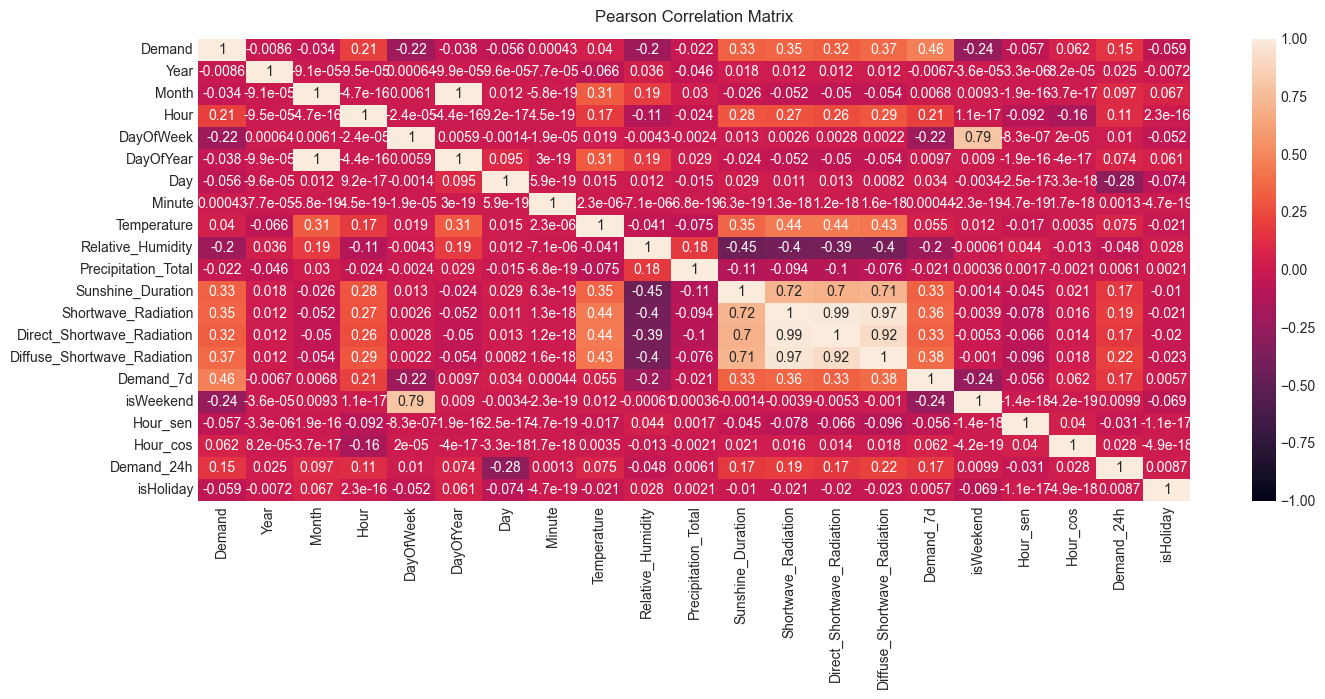

In [446]:
#Correlation Map using Pearson Correlation
plt.figure(figsize=(16,6))
corr_df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
#Drop Columns
corr_df = corr_df.drop(columns=["Date"])
heatmap = sns.heatmap(corr_df.corr('pearson'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Pearson Correlation Matrix', fontdict={'fontsize': 12}, pad=12)

In [447]:
columns2drop = ["Minute", "Hour_sen"]
corr_df = corr_df.drop(columns=columns2drop)
trainingSize = int(parameters["dataset"]["trainingSize"] * corr_df.shape[0])

X_new_train= corr_df.loc[:trainingSize, :].copy()
X_new_test = corr_df.loc[trainingSize:, :].copy()

#Standard Scale Numerical Variables
columns = list(X_new_train.columns)
columns.remove('Demand')
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), columns)
])
pip = Pipeline([('col_preprocessing', col_preprocessing)])
new_model = KNeighborsRegressor(n_neighbors=500, weights='uniform')

test(X_train = X_new_train, X_test = X_new_test, model = new_model)

49057
Test MAE: 23.414222983257233, MSE: 1296.1032960730593
